In [41]:
import pandas as pd
import numpy as np
from pathlib import Path

In [42]:
fln = Path(r"surfweer_data_2021_01_26.csv")

In [43]:
# Import the dataframe
df = pd.read_csv(fln, index_col= 0, parse_dates= ['report_date', 'post_date'])
df.reset_index(inplace=True, drop  = True)

# drop rows 

drop rows where 'day_of_week' has a value other than day of week

In [44]:
a = [ 'dinsdag', 'donderdag', 'maandag', 'vrijdag', 'weekend', 
     'woensdag', 'zaterdag', 'zondag']

df = df[df['day_of_week'].isin(a)].copy()

In [45]:
# drop the rows where no advice was offered 

df = df[df['day_of_week'] != df['wetsuit_adviezen']].copy()

# correct report dates

In [46]:
import datetime
import dateparser

def parse_post_date(post_title, **kwargs):
    """clean the post tile and parse as date

    Args:
        post_title (str): post title 

    Returns:
        post_date (datetime): 
    """    
    # do a bit cleaning 
    for key, value in kwargs.items(): 
        post_title = post_title.replace(key, value)
    
    # parse the date
    post_date = dateparser.parse(' '.join(post_title.split(' ')[-3::]))
    
    return post_date


def update_dates(post_date, report_weekday):
    """
    """
    weekdaag = {"maandag": 0,
                "dinsdag": 1,
                "woensdag": 2,
                "donderdag": 3,
                "vrijdag": 4,
                "zaterdag": 5,
                "zondag": 6}
    try:
        post_weekday = post_date.weekday()
        report_weekday = weekdaag[report_weekday]
        days_ahead = report_weekday - post_weekday
        report_date = post_date + datetime.timedelta(days_ahead)

        return report_date

    except:
        return np.nan

In [47]:
# a mapper used to clean the tile

mapper = {'-': ' ',
          'langste dag van': '20 June',
          'Koningsdag': '27 April'}

df['post_date'] = df['post_title'].apply(lambda x: parse_post_date(x, **mapper))

In [48]:
df = df.replace('weekend', 'zaterdag')

In [49]:
df['report_date'] = df.apply(
    lambda x: update_dates(x['post_date'], x['day_of_week']), axis=1)

# split the recommendations

into shoes.cap. gloves

In [50]:
import re

In [51]:
def hasNumbers(inputString):
     return any(char.isdigit() for char in inputString)

In [52]:
def str_to_dict(advice):
    try:
        advice = clean_string(advice)
        advice_list = advice.split(',')
        advice_list = [item for item in advice_list if hasNumbers(item)]

        values = []
        keys = []

        for item in advice_list:

            if bool(re.search('([A-z]+)', item)):
                key = re.search('([A-z]+)', item)[0]
            else:
                key = 'wetsuit'

            value = re.search('([0-9]+)', item)[0]

            keys.append(key)
            values.append(value)

        keys[0] = 'wetsuit'

        return dict(zip(keys, values))
    except:
        return None

In [53]:
def clean_string(advice):
    
    advice = advice.lower()
    advice = re.sub(r'met|\ben\b|&', ',', advice)
    advice = re.sub('-', ' ', advice)
    advice = re.sub('/', '', advice)
    advice = re.sub(r'mm\b', '', advice)
    
    advice = advice.replace('schoentjes', 'schoen')
    advice = advice.replace('schoen', ',schoen') # ensure properly separated
    advice = advice.replace('handschoen', 'hand')
    advice = advice.replace('want', 'hand')
#     advice = advice.replace('suit', 'wetsuit')
    advice = advice.replace('een', ' ')
    advice = advice.replace('of', ' ') ##
    
    return advice

In [54]:
df_wet = df['wetsuit_adviezen'].apply(lambda x:str_to_dict(x)).apply(pd.Series).copy()

In [55]:
df_combined = df.join(df_wet)

In [56]:
df_combined['wetsuit_adviezen'].isna().mean()

0.16956521739130434

# report summary

In [57]:
df_combined['month'] = df_combined['report_date'].dt.month
df_combined['year'] = df_combined['report_date'].dt.year

In [58]:
# correct the year for post-32948
df_combined.loc[df_combined['post_id'] == "post-32948", 'year'] = 2020

In [59]:
col_to_keep = [ 'report_date', 'report_content', 'day_of_week', 'post_date',
       'post_id', 'post_title', 'wetsuit_adviezen_str', 'wetsuit_adviezen',
       'post_url', 'wetsuit', 'hand', 'schoen', 'cap', 'month',
       'year']

In [60]:
df_combined_sub = df_combined[col_to_keep]

In [61]:
df_combined_sub.to_csv(fln.stem + '_clean.csv')

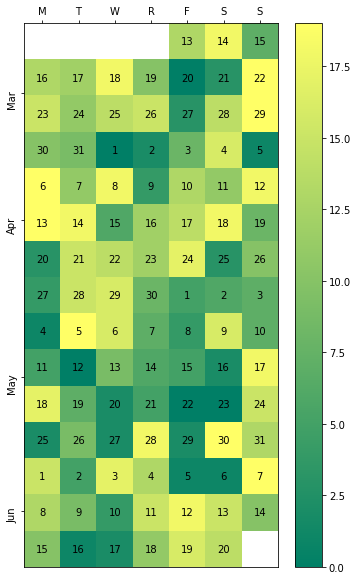

In [62]:
# reference 
